# DGLGraph と Node/Edge 特徴量

[DGLGraph and Node/edge Features — DGL 0.4 documentation](https://docs.dgl.ai/tutorials/basics/2_basics.html)

## グラフの作成

`DGLGraph` の設計は、他のグラフライブラリから着想を得ている。例えば `networkx` のグラフから `DGLGraph` を簡単に作成できるし、その逆も然り。

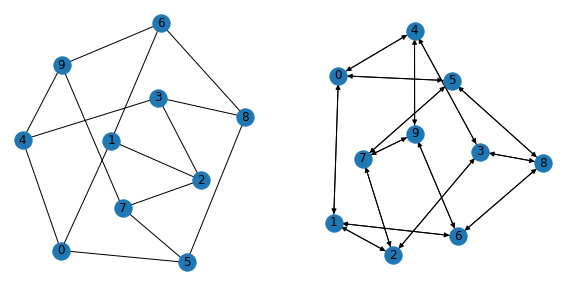

In [4]:
import networkx as nx
import dgl

g_nx = nx.petersen_graph()
g_dgl = dgl.DGLGraph(g_nx)

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
nx.draw(g_nx, with_labels=True, ax=axes[0])
nx.draw(g_dgl.to_networkx(), with_labels=True, ax=axes[1])

この例で、`DGLGraph` が常に有向グラフであること以外、まった同じようにグラフを扱えることがわかる。

次の例では、**スター (star)** と呼ばれる特殊なグラフを描写してみよう。
- `DGLGraph` ノードは、`0` から `number_of_nodes()` までの連続する整数値であり、`add_nodes` を呼ぶことで追加できる。
- `DGLGraph` エッジは、追加された順番で格納された、ノード対のリストです。

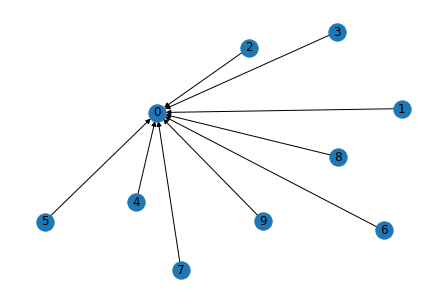

In [5]:
import dgl
import torch as th

g = dgl.DGLGraph()
g.add_nodes(10)

# 一つずつノードを追加
for i in range(1, 4):
    g.add_edge(i, 0)

# ソースのノード集合と宛先のノード集合を与えても良い
src = list(range(5, 8)); dst = [0]*3
g.add_edges(src, dst)

# Tensor オブジェクトでも可能
src = th.tensor([8, 9]); dst = th.tensor([0, 0])
g.add_edges(src, dst)

# Edge broadcasting will do star graph in one go!
g.clear()
g.add_nodes(10)
src = th.tensor(list(range(1, 10)))
g.add_edges(src, 0)

import networkx as nx
import matplotlib.pyplot as plt
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

## 特徴量の付与

`DGLGraph` のノードにもエッジにも特徴量を与えることができる。
特徴量は連想配列として表現され、**フィールド (field)** と呼ばれるテンソルと、その名前の文字列によって指定されます。

In [7]:
import dgl
import torch as th

x = th.randn(10, 3)
g.ndata['x'] = x

`ndata` はすべてのノード (の状態) にアクセスするための糖衣構文です。`ndata` で与えたフィールド (特徴量) は、各ノードの `data` プロパティからアクセスすることで、そのノードの特徴量のみを扱うことが出来ます。

In [8]:
print(g.ndata['x'] == g.nodes[:].data['x'])

# Access node set with integer, list, or integer tensor
g.nodes[0].data['x'] = th.zeros(1, 3)
g.nodes[[0, 1, 2]].data['x'] = th.zeros(3, 3)
g.nodes[th.tensor([0, 1, 2])].data['x'] = th.zeros(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])


エッジの特徴量に関しても同様に与えますが、endpoint と呼ばれる方法でエッジを指定しても良い点がエッジと異なります。

In [10]:
g.edata['w'] = th.randn(9, 2)

# Access edge set with IDs in integer, list, or integer tensor
g.edges[1].data['w'] = th.randn(1, 2)
g.edges[[0, 1, 2]].data['w'] = th.zeros(3, 2)
g.edges[th.tensor([0, 1, 2])].data['w'] = th.zeros(3, 2)

# You can also access the edges by giving endpoints
g.edges[1, 0].data['w'] = th.ones(1, 2)                 # edge 1 -> 0
g.edges[[1, 2, 3], [0, 0, 0]].data['w'] = th.ones(3, 2) # edges [1, 2, 3] -> 0

特徴量を与えたあとは、各ノード/エッジのフィールドは以下の要素を含む `Scheme` と呼ばれるオブジェクトが関連付きます。

- テンソルの shape
- データ種別 (dtype)
- フィールド (テンソルそのもの)

In [11]:
print(g.node_attr_schemes())
g.ndata['x'] = th.zeros((10, 4))
print(g.node_attr_schemes())

{'x': Scheme(shape=(3,), dtype=torch.float32)}
{'x': Scheme(shape=(4,), dtype=torch.float32)}


もちろん削除も可能です。データがメモリを圧迫しそうになった時は、積極的に実施すると良いかもしれません。

In [12]:
g.ndata.pop('x')
g.edata.pop('w')

tensor([[ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [-1.9631,  0.2735],
        [ 0.0326, -0.4437],
        [ 0.0718,  0.3560],
        [ 0.9848,  0.2180],
        [-1.1243, -0.9851],
        [ 1.7015,  2.4976]])

## マルチグラフを扱う

並行エッジ (同じノード対に対して複数のエッジが存在する状態) を扱う必要のある応用は多くあります。このために、`DGLGraph` では `multigraph=True` モードがあります。

以下は、`(1, 0)` に 2 個のエッジがある場合のマルチグラフの例です。

In [13]:
g_multi = dgl.DGLGraph(multigraph=True)
g_multi.add_nodes(10)
g_multi.ndata['x'] = th.randn(10, 2)

g_multi.add_edges(list(range(1, 10)), 0)
g_multi.add_edge(1, 0) # two edges on 1->0

g_multi.edata['w'] = th.randn(10, 2)
g_multi.edges[1].data['w'] = th.zeros(1, 2)
print(g_multi.edges())

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 1]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


マルチグラフのエッジは、ノード対 `u, v` では一意に特定出来ないので、`edge_id` インターフェイスを通した edge ID によるアクセスが必要となります。

In [14]:
eid_10 = g_multi.edge_id(1, 0)
g_multi.edges[eid_10].data['w'] = th.ones(len(eid_10), 2)
print(g_multi.edata['w'])

tensor([[ 1.0000,  1.0000],
        [ 0.0000,  0.0000],
        [ 1.2024,  1.0073],
        [-0.2985,  0.1380],
        [-0.9326, -0.5975],
        [-0.6429, -0.4419],
        [-0.5921,  0.3746],
        [ 0.8924, -1.1192],
        [ 0.8550, -2.6534],
        [ 1.0000,  1.0000]])
